## Predicción de Diabetes usando el Dataset Pima Indians

El Pima Indians Diabetes Database es uno de los datasets más utilizados en machine learning para problemas de clasificación binaria. Este dataset contiene información médica de mujeres de la tribu Pima de al menos 21 años de edad, y el objetivo es predecir si una persona tiene diabetes o no basándose en ciertas características médicas.

### Instalación de librerías necesarias

In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

### Configurar el estilo de las gráficas

In [4]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Carga y exploración inicial del dataset

In [5]:
df = pd.read_csv('diabetes.csv')

print("Forma del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())

Forma del dataset: (768, 9)

Primeras 5 filas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## Información general del dataset

In [6]:
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Estadísticas descriptivas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531

## Verificar valores nulos

In [7]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Distribución de la variable objetivo

In [8]:
print("\nDistribución de la variable objetivo (Outcome):")
print(df['Outcome'].value_counts())
print(f"\nPorcentaje de casos positivos: {df['Outcome'].mean()*100:.2f}%")


Distribución de la variable objetivo (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64

Porcentaje de casos positivos: 34.90%


## Crear subplots para visualizar la distribución de todas las variable

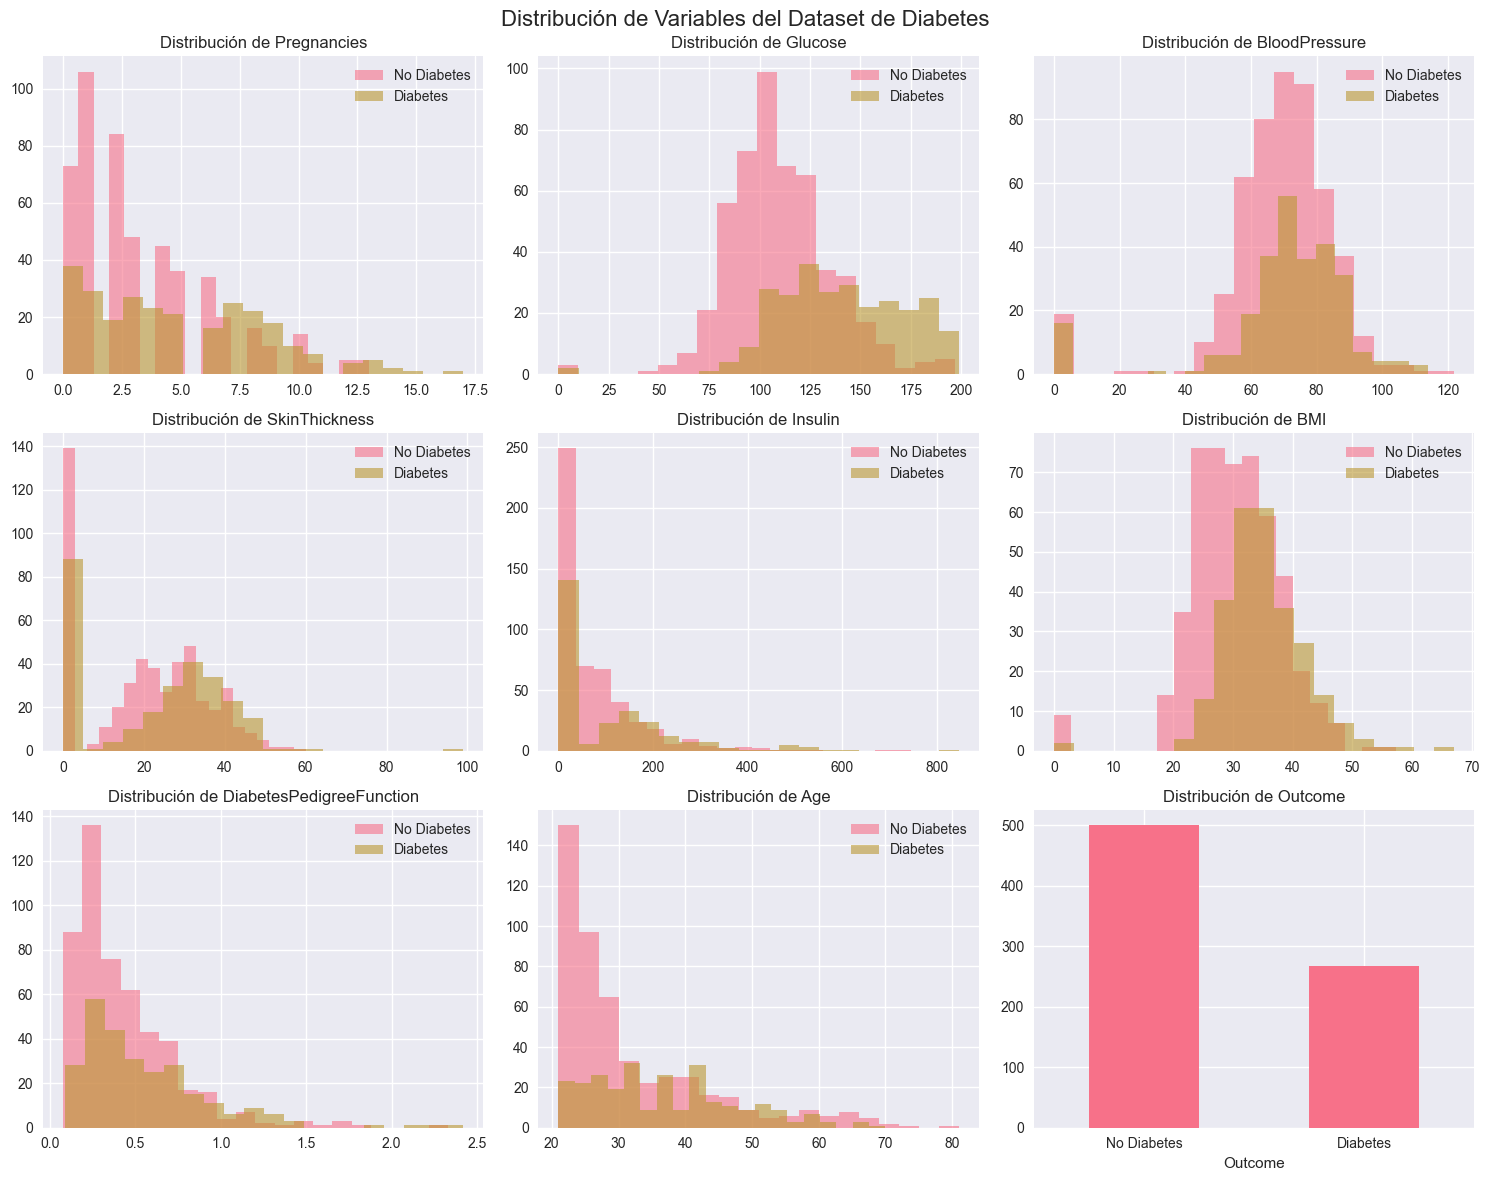

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribución de Variables del Dataset de Diabetes', fontsize=16)

columns = df.columns
for i, col in enumerate(columns):
    row = i // 3
    col_idx = i % 3
    
    if col != 'Outcome':
        df[df['Outcome']==0][col].hist(alpha=0.6, bins=20, ax=axes[row, col_idx], label='No Diabetes')
        df[df['Outcome']==1][col].hist(alpha=0.6, bins=20, ax=axes[row, col_idx], label='Diabetes')
        axes[row, col_idx].set_title(f'Distribución de {col}')
        axes[row, col_idx].legend()
    else:
        df['Outcome'].value_counts().plot(kind='bar', ax=axes[row, col_idx])
        axes[row, col_idx].set_title('Distribución de Outcome')
        axes[row, col_idx].set_xticklabels(['No Diabetes', 'Diabetes'], rotation=0)

plt.tight_layout()
plt.show()

## Matriz de correlación

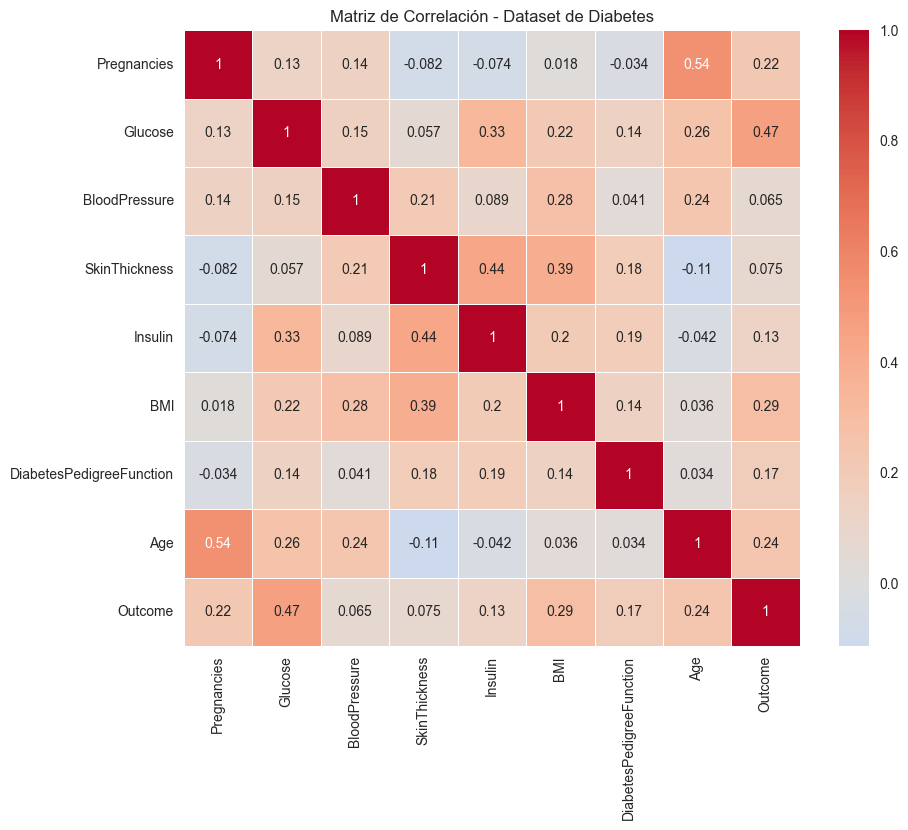

Correlaciones con la variable objetivo (Outcome):
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [10]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Dataset de Diabetes')
plt.show()

print("Correlaciones con la variable objetivo (Outcome):")
correlations = df.corr()['Outcome'].sort_values(ascending=False)
print(correlations)

## Detección y tratamiento de valores atípicos

In [11]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Valores cero en columnas críticas:")
for col in columns_with_zeros:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} valores cero ({zero_count/len(df)*100:.2f}%)")

df_processed = df.copy()

for col in columns_with_zeros:
    if col != 'Pregnancies': 
        median_value = df_processed[df_processed[col] != 0][col].median()
        df_processed[col] = df_processed[col].replace(0, median_value)
        
print(f"\nDataset después del preprocesamiento: {df_processed.shape}")

Valores cero en columnas críticas:
Glucose: 5 valores cero (0.65%)
BloodPressure: 35 valores cero (4.56%)
SkinThickness: 227 valores cero (29.56%)
Insulin: 374 valores cero (48.70%)
BMI: 11 valores cero (1.43%)

Dataset después del preprocesamiento: (768, 9)


## Preparación de datos para el modelo

In [12]:
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)
print("\nNombres de las características:")
print(list(X.columns))

Forma de X: (768, 8)
Forma de y: (768,)

Nombres de las características:
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


## División de datos en entrenamiento y prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaños de los conjuntos:")
print(f"Entrenamiento: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Prueba: X_test {X_test.shape}, y_test {y_test.shape}")

print(f"\nDistribución en entrenamiento: {y_train.mean()*100:.2f}% positivos")
print(f"Distribución en prueba: {y_test.mean()*100:.2f}% positivos")

Tamaños de los conjuntos:
Entrenamiento: X_train (614, 8), y_train (614,)
Prueba: X_test (154, 8), y_test (154,)

Distribución en entrenamiento: 34.85% positivos
Distribución en prueba: 35.06% positivos


## Normalizar las características usando StandardScaler

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Estadísticas después de la normalización:")
print("Media de X_train_scaled:", np.mean(X_train_scaled, axis=0).round(3))
print("Desviación estándar de X_train_scaled:", np.std(X_train_scaled, axis=0).round(3))

Estadísticas después de la normalización:
Media de X_train_scaled: [-0. -0.  0. -0. -0. -0. -0. -0.]
Desviación estándar de X_train_scaled: [1. 1. 1. 1. 1. 1. 1. 1.]


## Construcción del modelo de Regresión Logística con Keras

In [16]:
# Crear el modelo de regresión logística
model = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_scaled.shape[1],))
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Mostrar la arquitectura del modelo
print("Arquitectura del modelo:")
model.summary()

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [17]:
# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("Entrenamiento completado!")

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3650 - loss: 1.2463 - val_accuracy: 0.4065 - val_loss: 1.2941
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3611 - loss: 1.2633 - val_accuracy: 0.4065 - val_loss: 1.2601
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3375 - loss: 1.2073 - val_accuracy: 0.4065 - val_loss: 1.2275
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3556 - loss: 1.2530 - val_accuracy: 0.4228 - val_loss: 1.1941
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3632 - loss: 1.1948 - val_accuracy: 0.4146 - val_loss: 1.1627
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3483 - loss: 1.1637 - val_accuracy: 0.4228 - val_loss: 1.1319
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3563 - loss: 1.1826 - val_accuracy: 0.4228 - val_loss: 1.1011
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4439 - loss: 1.0709 - val_accuracy: 0.4146 - 

## Visualización del progreso del entrenamiento

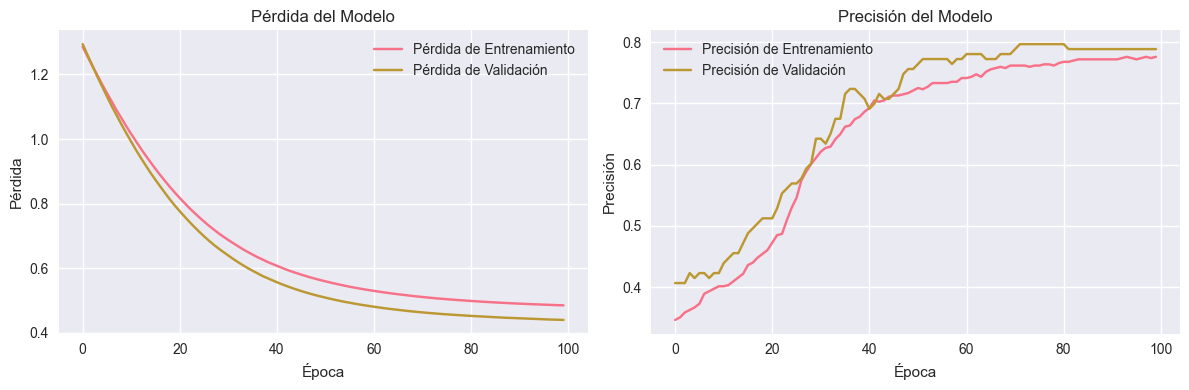

In [18]:
# Visualizar las métricas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida
ax1.plot(history.history['loss'], label='Pérdida de Entrenamiento')
ax1.plot(history.history['val_loss'], label='Pérdida de Validación')
ax1.set_title('Pérdida del Modelo')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfico de precisión
ax2.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
ax2.plot(history.history['val_accuracy'], label='Precisión de Validación')
ax2.set_title('Precisión del Modelo')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()

plt.tight_layout()
plt.show()

## Evaluación del modelo

In [19]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

Precisión en el conjunto de prueba: 0.7143
Pérdida en el conjunto de prueba: 0.5155


## Realizar predicciones

In [20]:
# Realizar predicciones en el conjunto de prueba
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("Primeras 10 predicciones (probabilidades):")
for i in range(10):
    print(f"Muestra {i+1}: Probabilidad = {y_pred_proba[i][0]:.4f}, "
            f"Predicción = {y_pred[i]}, Real = {y_test.iloc[i]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Primeras 10 predicciones (probabilidades):
Muestra 1: Probabilidad = 0.5714, Predicción = 1, Real = 0
Muestra 2: Probabilidad = 0.1249, Predicción = 0, Real = 0
Muestra 3: Probabilidad = 0.3133, Predicción = 0, Real = 0
Muestra 4: Probabilidad = 0.3364, Predicción = 0, Real = 1
Muestra 5: Probabilidad = 0.0727, Predicción = 0, Real = 0
Muestra 6: Probabilidad = 0.2065, Predicción = 0, Real = 0
Muestra 7: Probabilidad = 0.4275, Predicción = 0, Real = 1
Muestra 8: Probabilidad = 0.8743, Predicción = 1, Real = 1
Muestra 9: Probabilidad = 0.1215, Predicción = 0, Real = 0
Muestra 10: Probabilidad = 0.7595, Predicción = 1, Real = 0


## Métricas de evaluación detalladas

In [21]:
# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

Precisión: 0.7143

Reporte de clasificación:
              precision    recall  f1-score   support

 No Diabetes       0.76      0.81      0.79       100
    Diabetes       0.60      0.54      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.71      0.71      0.71       154



## Matriz de confusión

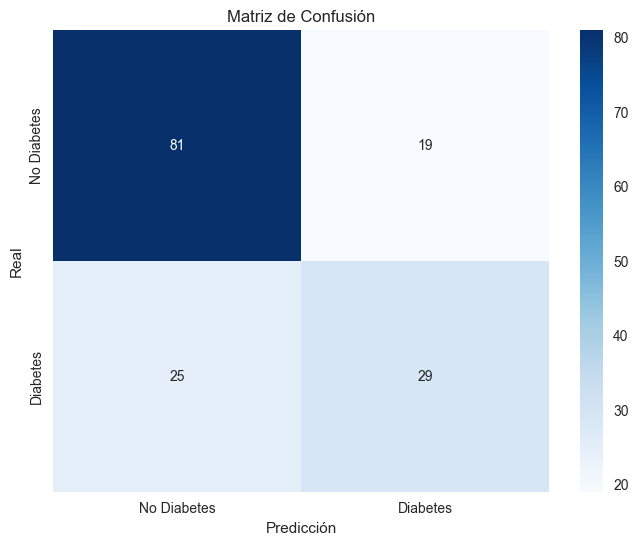


Métricas adicionales:
Verdaderos Negativos: 81
Falsos Positivos: 19
Falsos Negativos: 25
Verdaderos Positivos: 29
Sensibilidad (Recall): 0.5370
Especificidad: 0.8100
Precisión: 0.6042


In [22]:
# Crear y visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Calcular métricas adicionales
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall/Sensibilidad
specificity = tn / (tn + fp)  # Especificidad
precision = tp / (tp + fp)    # Precisión

print(f"\nMétricas adicionales:")
print(f"Verdaderos Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdaderos Positivos: {tp}")
print(f"Sensibilidad (Recall): {sensitivity:.4f}")
print(f"Especificidad: {specificity:.4f}")
print(f"Precisión: {precision:.4f}")

## Análisis de importancia de características (usando pesos del modelo)

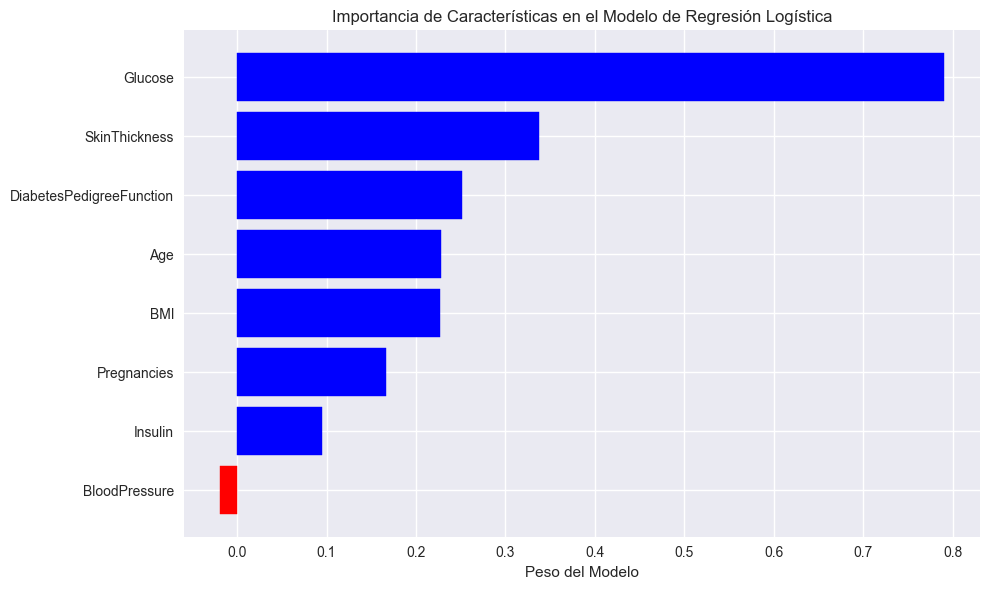

Importancia de características (ordenadas por valor absoluto):
             Característica      Peso  Importancia_Abs
1                   Glucose  0.790132         0.790132
3             SkinThickness  0.337084         0.337084
6  DiabetesPedigreeFunction  0.251838         0.251838
7                       Age  0.227596         0.227596
5                       BMI  0.226998         0.226998
0               Pregnancies  0.166052         0.166052
4                   Insulin  0.094774         0.094774
2             BloodPressure -0.019069         0.019069


In [23]:
# Obtener los pesos del modelo
weights = model.layers[0].get_weights()[0].flatten()
feature_names = X.columns

# Crear un DataFrame con los pesos
importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Peso': weights,
    'Importancia_Abs': np.abs(weights)
}).sort_values('Importancia_Abs', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Característica'], importance_df['Peso'])
plt.xlabel('Peso del Modelo')
plt.title('Importancia de Características en el Modelo de Regresión Logística')
plt.gca().invert_yaxis()

# Colorear las barras según el signo del peso
for i, bar in enumerate(bars):
    if importance_df.iloc[i]['Peso'] < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.tight_layout()
plt.show()

print("Importancia de características (ordenadas por valor absoluto):")
print(importance_df)

## Curva ROC y AUC

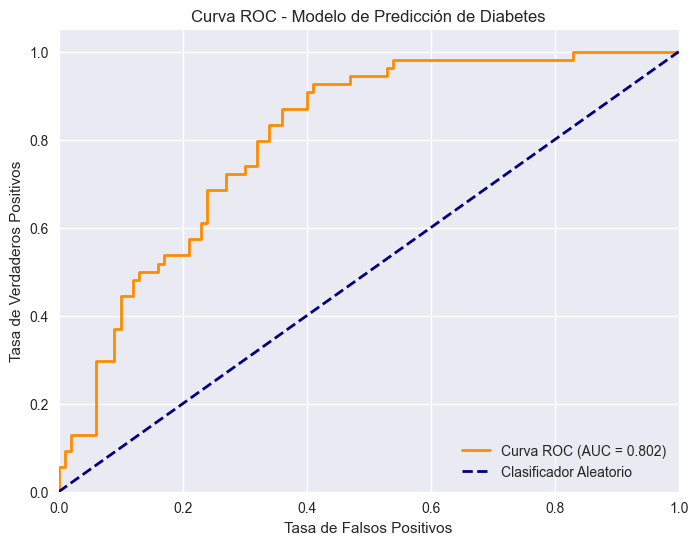

Área bajo la curva (AUC): 0.8022


In [24]:
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo de Predicción de Diabetes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Área bajo la curva (AUC): {roc_auc:.4f}")